In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
train=pd.read_csv('train.csv', index_col='Id')
test=pd.read_csv('test.csv', index_col='Id')
submission=pd.read_csv('sample_submission.csv', index_col='Id')
data=train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


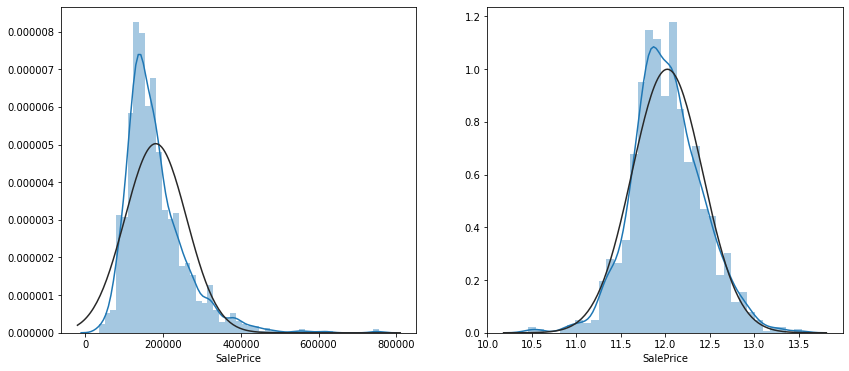

In [3]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1), fit=norm, ax=ax2)

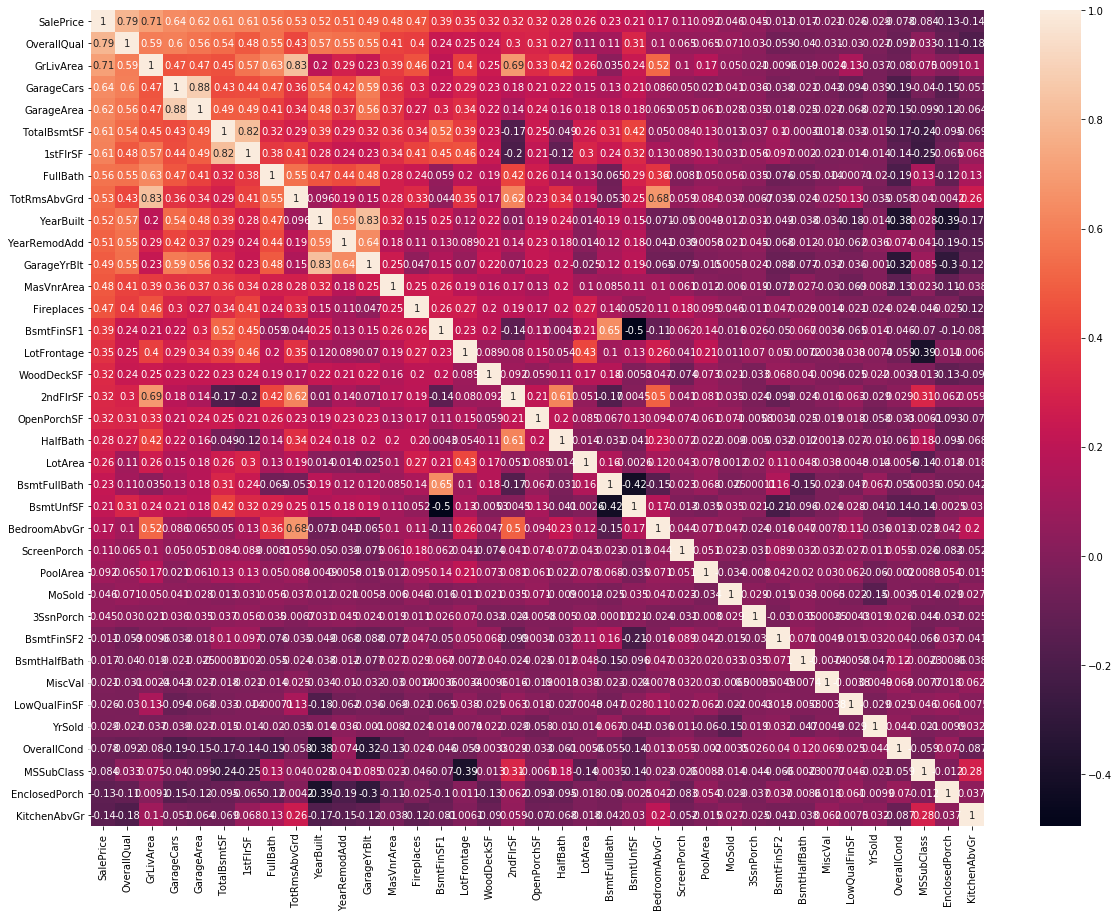

In [4]:
corr=data.corr()
top_corr=data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

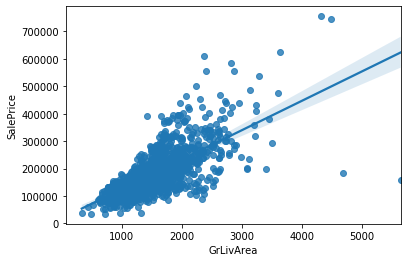

In [5]:
sns.regplot(data['GrLivArea'], data['SalePrice'])

In [6]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
Ytrain=train['SalePrice']
train=train[list(test)]
all_data=pd.concat((train, test), axis=0)
print(all_data.shape)
Ytrain=np.log1p(Ytrain)

(2917, 79)


In [7]:
###########################null값 없애기############################
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))


for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")


34
Total count of missing values in all_data : 0


In [8]:
###################총 면적, 총 욕실 수 COL 추가####################
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

In [9]:
#######################연도는 스트링이 맞음###################
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)

In [10]:
##############데이터중 비정상적으로 하나의 값이 많음###############
all_data=all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

In [11]:
all_data=all_data.drop(columns=['PoolArea','PoolQC'])

In [12]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

In [13]:
######################원 핫 인코딩###################3
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col], prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 297)


In [14]:
#######################right skewed가 큰 변수들 처리##############
numeric=all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))


252 features had been tranformed
(2917, 297)


In [15]:
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 297) (1459, 297)


In [16]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV
import xgboost as xgb
import lightgbm as lgb


In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(Xtrain, Ytrain)
lasso_preds = np.expm1(model_lasso.predict(Xtest))

model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(Xtrain, Ytrain)
xgb_preds = np.expm1(model_xgb.predict(Xtest))

model_ridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(Xtrain, Ytrain)
ridge_preds = np.expm1(model_ridge.predict(Xtest))

elastic_model = ElasticNetCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(Xtrain, Ytrain)
elastic_preds = np.expm1(elastic_model.predict(Xtest))

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=5000,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

lgbm_fit = model.fit(Xtrain, Ytrain)

lgb_preds = np.expm1(lgbm_fit.predict(Xtest))

preds = 0.2*lasso_preds + 0.2*xgb_preds+0.2*lgb_preds+0.2*ridge_preds+0.2*elastic_preds
submission['SalePrice']=preds
submission.to_csv('submission.csv')
#solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
#solution.to_csv("submission.csv", index = False)